# Assignment 3

As before, if a question can be answered with 'yes/no', or a numeric value, you may simply state as much. If you incorporate code from the internet (which is not required and generally not advisable), please cite the source within your code (providing a URL is sufficient).

We will go through comparable code and concepts in the live learning session. If you run into trouble, start by using the help `help()` function in Python, to get information about the datasets and function in question. The internet is also a great resource when coding (though note that no outside searches are required by the assignment!). If you do incorporate code from the internet, please cite the source within your code (providing a URL is sufficient).

Please bring questions that you cannot work out on your own to office hours, work periods or share with your peers on Slack. We will work with you through the issue.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Question 1: Resampling via Bootstrapping

Now, we'll use the `iris` dataset, which we will add to Python using the `statsmodels` library. As always, start by reviewing a description of the dataset, by printing the dataset.

In [18]:
# Import
iris = sm.datasets.get_rdataset('iris', 'datasets')
df = pd.DataFrame(iris.data)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


_(i)_ Create an `alpha_func(D, idx)` function which takes the `Sepal`'s `width` and `length` to calculate for alpha

In [78]:
def alpha_func(D, idx):
    cov_ = np.cov(D[['Sepal.Length','Sepal.Width']].loc[idx], rowvar=False)
    return ((cov_[1,1] - cov_[0,1]) / (cov_[0,0]+cov_[1,1]-2*cov_[0,1]))


Test the code below

In [79]:
alpha_func(df, range(100))

0.38105014898343803

_(ii)_ Construct a new bootstrap data set and recompute alpha

In [70]:
rng = np.random.default_rng(0)
alpha_func(df, rng.choice(100, 100, replace=True))

0.3324645134841774

Imagine we are analysts working for a shipping company. The company wants to know the average length of iris' petals, to inform space allotment on an upcoming shipment. The relevant variable in the dataset is `Sepal.Length`. 

_(iii)_ Why is it (perhaps) not sufficient to simply calculate the mean of `Sepal.Length`? What more information will preforming a bootstrap provide to us?  

_(iv)_ We can perform bootstrapping in Python by defining a simple function using `boot_SE()` for computing the bootstrap standard error. Remember, because bootstrapping involves randomness, we must first set a seed for reproducibility!

In [71]:
'''
(iii)
Simply calculating the mean of Sepal.Length gives us an estimate of the central tendency of the petal lengths in the dataset.
However, this single value does not provide information about the variability or the uncertainty associated with this estimate.
Specifically, it doesn't tell us how much the mean might change if we were to take different samples from the same population.

Bootstrapping, on the other hand, provides additional information about the distribution of the sample mean.
By repeatedly resampling the data with replacement and calculating the mean for each sample, we can obtain a distribution of the sample means.

This allows us to:
1) Estimate the standard error: the standard deviation of the bootstrapped sample means gives us an estimate of the standard error of the mean,
which quantifies the variability of the sample mean.
2) Construct confidence intervals: using the bootstrapped distribution, we can construct confidence intervals to provide a range within which the true
population mean is likely to lie.
3) Assess stability: bootstrapping helps assess the stability and reliability of the sample mean estimate by showing how it varies across different samples.
'''


# (iv)

bootstrap_values = []

def boot_SE(D, B=1000, seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = D.shape[0]
    for i in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = alpha_func(D, idx)
        bootstrap_values.append(value)
        
    return np.std(np.array(bootstrap_values))


_(v)_ Evaluate the accuracy of our alpha estimate with B = 1000

In [72]:
alpha_SE = boot_SE(D=df,
                   B=1000,
                   seed=0)
alpha_SE

0.03180510076860767

_(vi)_ What is the original mean value of `Sepal.Length`?

In [74]:
print(
    round(df['Sepal.Length'].mean(),4)
    )

5.8433


Next, let's create a new bootstrapping to bootstrap samples (`boot_se_samples`) of `Sepal.Length`, in order to compute its bootstrapped mean and standard deviation.

_(vii)_. Write code to review the bootstrapped mean value, and the standard deviation of the bootstrapped samples. Compare the mean against its original value. Then, review the bootstrapped range, by using `t_range = np.ptp(boot_se_samples)`.

In [75]:
sepal_length = df['Sepal.Length'].values

np.random.seed(50)

# Define a function to perform bootstrapping
def boot_se_samples(data, num_bootstrap=1000):
    boot_samples = []
    n = len(data)
    
    for _ in range(num_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        boot_samples.append(sample)
    
    return np.array(boot_samples)

boot_samples = boot_se_samples(sepal_length)

# Calculate the bootstrapped means
boot_means = np.mean(boot_samples, axis=1)

# Calculate the original mean value of Sepal.Length
original_mean = sepal_length.mean()

# Calculate the mean and standard deviation of the bootstrapped means
boot_mean = np.mean(boot_means)
boot_std = np.std(boot_means)

# Calculate the range of the bootstrapped means
t_range = np.ptp(boot_means)

print(f"Original mean of Sepal.Length: {original_mean:.4f}")
print(f"Bootstrapped mean of Sepal.Length: {boot_mean:.4f}")
print(f"Standard deviation of bootstrapped means: {boot_std:.4f}")
print(f"Range of bootstrapped means: {t_range:.4f}")

Original mean of Sepal.Length: 5.8433
Bootstrapped mean of Sepal.Length: 5.8412
Standard deviation of bootstrapped means: 0.0674
Range of bootstrapped means: 0.4500


_(viii)_ Next, let's compute 95% confidence intervals, for the mean value of iris sepal length. (Hint: use the `np.percentile` function)

In [76]:
ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)

print(f"95% Confidence Interval for the mean value of Sepal.Length: [{ci_lower:.4f}, {ci_upper:.4f}]")

95% Confidence Interval for the mean value of Sepal.Length: [5.7160, 5.9813]


_(ix)_. Use the plot function to create an histogram of the bootstrapped samples. What does this histogram show ?

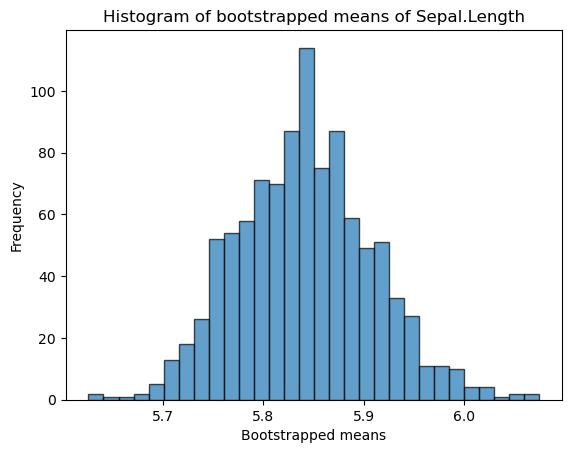

'\nThe histogram shows that the distribution of Sepal.Length is approximately normal and symmetric, with no significant outliers.\nThe bootstrapped mean of Sepal.Length is approximately 5.84 cm. This value is very close to the original sample mean, indicating consistency in our estimation.\nThis consistency suggests a low risk of encountering unexpected extreme values.\n'

In [77]:
#Complete this

# Create a figure and axis
fig, ax = plt.subplots()

# Create the histogram
ax.hist(boot_means, bins=30, edgecolor='k', alpha=0.7)

# Add a title
ax.set_title('Histogram of bootstrapped means of Sepal.Length')

# Add a label to the x-axis
ax.set_xlabel('Bootstrapped means')

# Add a label to the y-axis
ax.set_ylabel('Frequency')

# Show the plot
plt.show()

'''
The histogram shows that the distribution of Sepal.Length is approximately normal and symmetric, with no significant outliers.
The bootstrapped mean of Sepal.Length is approximately 5.84 cm. This value is very close to the original sample mean, indicating consistency in our estimation.
This consistency suggests a low risk of encountering unexpected extreme values.
'''

_(x)_ Given your bootstrapped analysis, what do you recommend to shipping company? 

In [ ]:
'''
Based on the bootstrapped analysis, the shipping company should use an average Sepal.Length of approximately 5.84 cm
for space planning, while considering a range of 5.7 cm to 5.9 cm to account for variability.
This approach will help optimize space utilization and manage the risk of variability in sepal lengths.
Continued monitoring and updating of the analysis will ensure that the company's space planning remains accurate and reliable.
'''

# Criteria

|Criteria            |Complete           |Incomplete          |
|--------------------|---------------|--------------|
|Bootstrapping|All steps are done correctly and the answers are correct.|At least one step is done incorrectly leading to a wrong answer.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Note:

If you like, you may collaborate with others in the cohort. If you choose to do so, please indicate with whom you have worked with in your pull request by tagging their GitHub username. Separate submissions are required.


### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/applying_statistical_concepts/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [X] Created a branch with the correct naming convention.
- [X] Ensured that the repository is public.
- [X] Reviewed the PR description guidelines and adhered to them.
- [X] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
